In [1]:
import numpy as np
rd_st = np.random.RandomState(42)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import osmnx as ox
import shapely
import warnings
warnings.filterwarnings('ignore')

import multiprocessing
from multiprocessing import Pool

import time
import ipdb
from IPython import display

%matplotlib inline

In [2]:
from rider import *

# Load data, road network

In [3]:
rand_merchant = np.random.choice(nodes['NodeName'], 10)
rand_merchant

array([5272396527, 9443678275, 1717842431,  258023982, 1654121831,
        476450460,  137302583, 6038627989, 6749053150,  245568668])

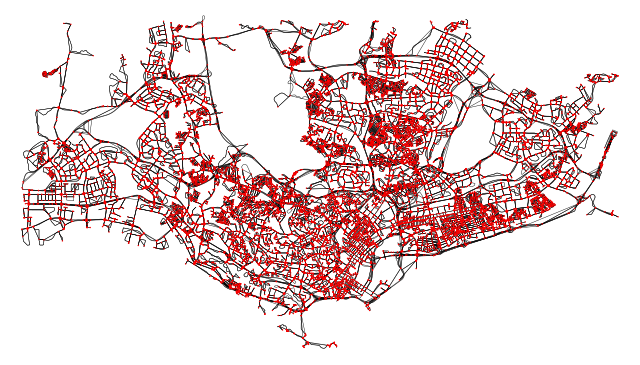

In [4]:
fig, ax = ox.plot.plot_graph(
    G_sgp, node_size=1, node_color='r', bgcolor='w', edge_color='k',
    edge_linewidth=.3, save=0, show=False, close=False
)

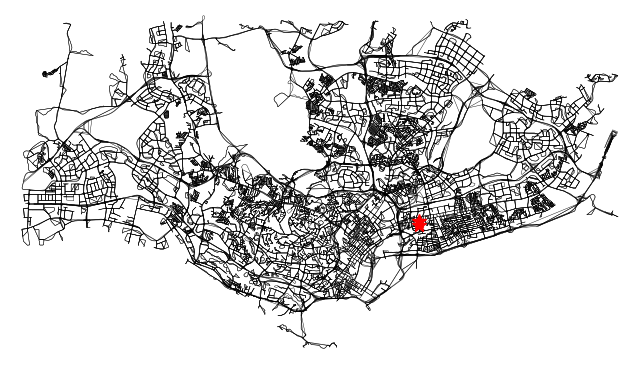

In [18]:
fig, ax = ox.plot.plot_graph(
    G_sgp, node_size=0, bgcolor='w', edge_color='k',
    edge_linewidth=.3, save=0, show=False, close=False
)

for i in [3973745890, 172548911]:
    ax.plot(
        nodes.loc[nodes['NodeName']==i, 'x'].values[0],
        nodes.loc[nodes['NodeName']==i, 'y'].values[0],
        'r*', markersize=10)


In [4]:
# defined in rider.py
nodes.head()

,NodeName,x,y
0,25451915,103.978767,1.334762
1,25451918,103.973936,1.327573
2,25451929,103.872544,1.295232
3,25455287,103.874004,1.295445
4,25455292,103.908497,1.301013


In [5]:
# defined in rider.py
edges.head()

,EdgeName,from,to,distance,osmid,maxspeed,travel_time_minimum
0,0,25451915,25451918,0.963113,"[166741187, 649636776, 649636777, 717446235, 2...",90,0.010701
1,1,25451918,242636478,0.278409,22617511,50,0.005568
2,2,25451918,1143899970,0.670252,166741192,90,0.007447
3,3,25451929,6749812859,0.765032,"[49961799, 718881456, 741164883, 754786742, 17...",70,0.010929
4,4,25455287,1637003462,0.629055,150829205,50,0.012581


Try Dijkstra method

# Define rider

In [6]:
# in rider.py

# Define platform


In [7]:
class platform:
    def __init__(self, r, cR, k, t):
        self.customer_df = pd.DataFrame(
            [],
            columns=[
                'node_ID',
                'merchant_node',
                'waiting_time',
                'position_x',
                'position_y'
            ]
        )

        self.matched_customer_df = pd.DataFrame(
            [],
            columns=[
                'node_ID',
                'merchant_node',
                'waiting_time',
                'position_x',
                'position_y'
            ]
        )
        
        self.num_accumulated_order = 0
        self.r = r
        self.cR = cR
        self.k = k
        self.t = t
    
    def update_cust_df_with_new_rand_num_cust(self, n=1):
        c = 0
        while True and n > 0:
            ind = self.customer_df.shape[0]
            node_ID = rd_st.choice(list(nodes['NodeName']))
            node_position = get_node_xy(node_ID)
            merchant_node = rd_st.choice(merchant_node_set)
            
            if np.linalg.norm(node_position - get_node_xy(merchant_node)) < cR:
                new_customer = pd.DataFrame(
                    [[node_ID, merchant_node, 0, node_position[0], node_position[1]]],
                    index=[ind],
                    columns=['node_ID', 'merchant_node', 'waiting_time', 'position_x', 'position_y']
                )
                self.customer_df = pd.concat([self.customer_df, new_customer], axis=0, ignore_index=True)
                c = c + 1
                
            if c == n:
                break
    
    def acquire_order(self, q):
        # num_generated_order_c is continuous ('_c'), not discrete
        num_generated_order_c = rd_st.rand() * q * t_resolution * 2
        self.num_accumulated_order += num_generated_order_c
        num_generated_order = int(self.num_accumulated_order - self.customer_df.shape[0])
        
        self.update_cust_df_with_new_rand_num_cust(num_generated_order)
        
        self.customer_df['waiting_time'] = self.customer_df['waiting_time'] + t_resolution
        self.matched_customer_df['waiting_time'] = self.matched_customer_df['waiting_time'] + t_resolution

    def update_matched_order(self, matched_batches):
        for i in matched_batches.flatten():
            first_cust_ind = self.customer_df.loc[self.customer_df['node_ID']==i, 'waiting_time'].astype(float).idxmax()
            self.matched_customer_df = self.matched_customer_df.append(self.customer_df.loc[first_cust_ind])
            self.customer_df = self.customer_df.drop(index=first_cust_ind)
        
        self.matched_customer_df.index = range(self.matched_customer_df.shape[0])
        self.customer_df.index = range(self.customer_df.shape[0])
        
        self.num_accumulated_order -= matched_batches.size
    
    def match(self, idle_rider_IDs, rider_set):
        # when multiprocessing, the rider ID and index of each rider
        # in the rider_set list are not necessarily the same
        rider_ID_set = [i.ID for i in rider_set]
        rider_index_df = pd.DataFrame(range(len(rider_ID_set)), index=rider_ID_set, columns=['ind'])
        
        matched_batches = []
        matched_rider_IDs = []
        matched_merchants = []
        
        for i in range(len(merchant_node_set)):
            # first find corresponding idle rider IDs
            merchant_node = merchant_node_set[i]
            idle_rider_IDs_this_merchant = []
            for idle_rider_ID in idle_rider_IDs:
                idle_rider = rider_set[rider_index_df.loc[idle_rider_ID, 'ind']]
                if idle_rider.closest_merchant_node==merchant_node:
                    idle_rider_IDs_this_merchant.append(idle_rider_ID)
            n_idle_riders_this_merchant = len(idle_rider_IDs_this_merchant)
            
            # accumulatd orders for this merchant
            acc_ord_this_mer_df = self.customer_df.loc[self.customer_df['merchant_node']==merchant_node]
            acc_ord_this_mer = acc_ord_this_mer_df['node_ID'].astype(int).values
            
            num_required_riders_this_merchant = min(
                n_idle_riders_this_merchant,
                # number of accumulated orders for this merchant // k
                len(acc_ord_this_mer) // self.k
            )
            
            matched_rider_IDs_this_merchant = list(rd_st.choice(
                idle_rider_IDs_this_merchant,
                num_required_riders_this_merchant,
                replace=False
            ))

            matched_batches_this_merchant = []
            for j in range(len(matched_rider_IDs_this_merchant)):
                matched_batches_this_merchant.append(acc_ord_this_mer[self.k*j:self.k*(j+1)])
                matched_merchants.append(merchant_node)
            matched_batches_this_merchant = np.array(matched_batches_this_merchant)
            
            matched_batches.extend(matched_batches_this_merchant)
            matched_rider_IDs.extend(matched_rider_IDs_this_merchant)

        matched_batches = np.array(matched_batches)
        # remove the matched orders
        self.update_matched_order(matched_batches)
        W_cq_4_matched_customers = []
        for i in np.array(matched_batches).flatten():
            W_cq_4_matched_customers.append(self.customer_df['waiting_time'])
        avg_W_cq = np.mean(W_cq_4_matched_customers) if len(W_cq_4_matched_customers)>0 else np.nan
        
        # their indexes are mutually matched
        return matched_batches, matched_rider_IDs, matched_merchants, avg_W_cq  
        

In [8]:
# Multi processing, but it is slower if the step length is small, say, one
def move_all_riders():
    # number of riders at each process
    N_each_process = N // (n_cpu - 1) if N%n_cpu != 0 else N // n_cpu
    n_process = N//N_each_process+1 if N%N_each_process != 0 else N//N_each_process

    params = []
    for i in range(n_process):
        params.append(
            [
                rider_set[i*N_each_process:(i+1)*N_each_process],
                t_resolution,
                matched_rider_IDs,
                matched_batches,
                matched_merchants,
                dec_var
            ]
        )
    
    moved_rider_set = pool.starmap(func=move_rider, iterable=params )
    return moved_rider_set


In [16]:
class rider:
    def __init__(self, config, dec_var, merchant_node_set, rd_st=np.random.RandomState(42)):
        # config is a dictionary
        self.ID = config['ID']                                  # scalar
        self.position = config['initial_position']              # 1-D array, [x, y]
        self.maxspeed = config['maxspeed']                      # scalar
        self.stop_time = 0                                      # scalar, float
        self.state = 'idle'                                     # string 'idle' or 'working' or 'stop'
        self.speed = self.maxspeed / 2
        self.if_matched = False
        self.customer_nodes = []
        self.newly_finished_destination = None
        self.merchant_node = None
        self.total_time = 0
        self.total_time_rec = []
        self.if_matchable = False
        self.merchant_node_set = merchant_node_set
        self.rd_st = rd_st

        adj_node, adj_node_position = get_adj_node_position(self.position)
        self.position = adj_node_position
        self.closest_merchant_node = get_closest_node(self.position, self.merchant_node_set)
        if np.linalg.norm(adj_node_position - self.position) == 0:
            self.direction = norm_vec(self.rd_st.rand(2))
        else:
            self.direction = norm_vec(adj_node_position - self.position)

        self.prev_node = adj_node  # possible to contain current pos
        self.next_node = self.rd_st.choice([i for i in G_sgp.neighbors(self.prev_node)])
        self.update_idle_destination()  # update destination, path_to_dest, nextnext_node
        self.link = get_link(G_sgp, self.prev_node, self.next_node)

        self.dec_var = dec_var  # decision variables

    def update_customer_order(self):
        new_customer_nodes = []
        customer_2_merchant_distance_set = []
        for customer in self.customer_nodes:
            customer_2_merchant_distance_set.append(np.linalg.norm(get_node_xy(customer) - get_node_xy(self.merchant_node)))

        d_min = min(customer_2_merchant_distance_set)
        d_min_ind = customer_2_merchant_distance_set.index(d_min)

        # time complexity O(n^2)
        for i in range(len(self.customer_nodes)):
            for customer in self.customer_nodes:
                if np.linalg.norm(get_node_xy(self.merchant_node) - get_node_xy(customer)) > d_min:
                    d_min = np.linalg.norm(get_node_xy(self.merchant_node) - get_node_xy(customer))
                    new_customer_nodes.append(customer)
        new_customer_nodes.append(self.customer_nodes[d_min_ind])
        self.customer_nodes = new_customer_nodes

    def update_att_according_to_the_next_cust(self):
        self.update_customer_order()
        # rider merchant_node has been updated in function "move_rider"
        self.destination = self.merchant_node
        self.path_to_dest = nx.dijkstra_path(G_sgp, self.next_node, self.destination)

        # next node is the last node, then the next next node is random, else, nextnext node is the second node of the path
        self.nextnext_node = self.rd_st.choice([i for i in G_sgp.neighbors(self.next_node)]) if self.next_node == self.path_to_dest[-1] else self.path_to_dest[1]

        # when matched, set the driver to be unmatchable
        self.if_matchable = False

    def check_distance_2_closest_merchant(self):
        self.closest_merchant_node = get_closest_node(self.position, self.merchant_node_set)

        closest_merchant_position = get_node_xy(self.closest_merchant_node)
        if np.linalg.norm(self.position - closest_merchant_position) * 111 <= self.dec_var['r']:  # from lon-lat system to km
            self.if_matchable = True
        else:
            self.if_matchable = False

    def move(self, travel_distance_mag, t_resolution, dec_var):
        self.newly_finished_destination = None
        self.dec_var = dec_var
        # move one time step foward
        if self.state == 'idle':
            self.check_distance_2_closest_merchant()
            if self.if_matched:
                self.state = 'working'
                self.speed = self.maxspeed
                # customer_nodes has been updated in function "move_rider"
                self.update_att_according_to_the_next_cust()
        elif self.state == 'working':
            None
        elif self.state == 'stop':
            self.stop(t_resolution)
            return

        # the current link
        link_geometry = self.link['geometry']
        # first and last node of the geometry of this link
        first_point, last_point = link_geometry.coords[0], link_geometry.coords[-1]
        first_node = nodes.loc[(nodes['x'] == first_point[0]) & (nodes['y'] == first_point[1]), 'NodeName'].iloc[0]
        last_node = nodes.loc[(nodes['x'] == last_point[0]) & (nodes['y'] == last_point[1]), 'NodeName'].iloc[0]

        # whether the direction of the link is the reverse of our traveling direction
        reverse = (self.prev_node != first_node) and (self.next_node != last_node)
        if reverse:
            link_geometry = shapely.geometry.LineString(list(link_geometry.coords)[::-1])

        # the remaining length from current location to the next node
        distance_to_next_node = link_geometry.length - link_geometry.project(shapely.geometry.Point(self.position))

        if travel_distance_mag < distance_to_next_node:
            # self.position = self.position + travel_distance_mag * self.direction
            new_position_point = link_geometry.interpolate(link_geometry.project(shapely.geometry.Point(self.position)) + travel_distance_mag)
            self.position = np.array([new_position_point.x, new_position_point.y])
        elif travel_distance_mag >= distance_to_next_node:
            # the residual distance to travel
            travel_distance_mag -= distance_to_next_node

            # travel to the next node
            next_node_position = get_node_xy(self.next_node)
            self.position = next_node_position
            self.prev_node = self.next_node
            self.next_node = self.nextnext_node

            # update nextnext_node
            if self.prev_node == self.destination:  # prev_node is the current node
                # arrive the destination
                # give up the residual distance, and stop
                if self.state == 'working':
                    self.stop(t_resolution)
                elif self.state == 'idle':
                    self.nextnext_node = self.rd_st.choice([i for i in G_sgp.neighbors(self.next_node)])
                else:
                    None
            else:
                if self.next_node != self.destination:
                    # the next_node is not the destination
                    try:
                        self.nextnext_node = self.path_to_dest[self.path_to_dest.index(self.next_node) + 1]
                    except:
                        ipdb.set_trace()
                elif self.next_node == self.destination:
                    # the next_node is the destination, then randomly choose on for
                    # nextnext_node
                    self.nextnext_node = self.rd_st.choice([i for i in G_sgp.neighbors(self.next_node)])
                else:
                    None

                self.move(travel_distance_mag, t_resolution, dec_var)
        else:
            None
        
        if self.state == 'idle':
            self.update_idle_destination()
        else:
            None

        # finish moving, add total_time and update link
        self.total_time += t_resolution
        self.link = get_link(G_sgp, self.prev_node, self.next_node)
        

    def stop(self, t_resolution):
        # when pickup, delivered, or else
        self.state = 'stop'
        if self.stop_time > 0.1:
            # restart
            self.state = 'working'
            self.stop_time = 0
            self.newly_finished_destination = self.destination  # consider the current destination as finished
            self.update_next_desination(t_resolution)
        else:
            self.stop_time = self.stop_time + t_resolution

    def update_next_desination(self, t_resolution):
        next_destination = self.customer_nodes[0] if len(self.customer_nodes) > 0 else None
        if next_destination is None:
            # complete
            self.complete()
            return
        next_dest_i = self.customer_nodes.index(next_destination)
        # udpate customer_nodes
        new_customer_nodes = []
        new_customer_nodes.extend(self.customer_nodes[:next_dest_i])
        new_customer_nodes.extend(self.customer_nodes[next_dest_i+1:])
        self.customer_nodes = new_customer_nodes

        self.destination = next_destination
        self.path_to_dest = nx.dijkstra_path(G_sgp, self.prev_node, self.destination)  # prev_node is current location

        # update the next_node, and nextnext_node
        if len(self.path_to_dest) == 1:
            self.stop(t_resolution)
            return
        else:
            self.next_node = self.path_to_dest[1]

        # if only 2 nodes, then nextnext node is random
        self.nextnext_node = self.path_to_dest[2] if len(self.path_to_dest) > 2 else self.rd_st.choice([i for i in G_sgp.neighbors(self.next_node)])
        next_node_position = get_node_xy(self.next_node)
        self.direction = norm_vec(next_node_position - self.position)

    def complete(self):
        # complete all orders in current bundle
        print('rider %i completed! time:%.2f' % (self.ID, self.total_time))
        self.update_idle_destination()

        self.state = 'idle'
        self.speed = self.maxspeed / 2
        self.if_matched = False
        self.customer_nodes = []
        self.merchant_node = None
        self.total_time_rec.append(self.total_time)
        self.total_time = 0
        return

    def update_idle_destination(self):
        self.closest_merchant_node = get_closest_node(self.position, self.merchant_node_set)
        try:
            self.destination = self.closest_merchant_node
            # previous node is the current node
            self.path_to_dest = nx.dijkstra_path(G_sgp, self.next_node, self.destination)
            # update the next_node, and nextnext_node
            if len(self.path_to_dest) == 1:
                self.nextnext_node = self.rd_st.choice([i for i in G_sgp.neighbors(self.next_node)])
            elif len(self.path_to_dest) > 1:
                self.nextnext_node = self.path_to_dest[1]
            else:
                None
        except:
            # if there is no route
            # update the nextnext_node
            self.nextnext_node = self.rd_st.choice([i for i in G_sgp.neighbors(self.next_node)])
            self.destination = self.next_node
            self.path_to_dest = nx.dijkstra_path(G_sgp, self.next_node, self.destination)


def move_rider(rider_set, t_resolution, matched_rider_IDs, matched_batches, matched_merchants, dec_var):
    for i in range(len(rider_set)):
        rider_i = rider_set[i]
        if rider_i.ID in matched_rider_IDs:
            # if this rider is mathced, update if_matched
            rider_i.if_matched = True
            # find corresponding index of rider in matched_rider_IDs
            batch_index = matched_rider_IDs.index(rider_i.ID)

            # get the corresponding matched batch and update to customer_nodes
            rider_i.customer_nodes = list(matched_batches[batch_index, :])
            # get the corresponding matched merchant and update to merchant_node
            rider_i.merchant_node = matched_merchants[batch_index]
            # move rider with updated customer_nodes
            travel_distance_mag = rider_i.speed * t_resolution
            rider_i.move(travel_distance_mag, t_resolution, dec_var)
        else:
            travel_distance_mag = rider_i.speed * t_resolution
            rider_i.move(travel_distance_mag, t_resolution, dec_var)

    return rider_set


# some useful utility functions
def norm_vec(a):
    return (np.array(a) / np.linalg.norm(np.array(a))).flatten()


def get_node(ID):
    node_index = nodes.loc[nodes['NodeName'] == ID].index.values[0]
    return node_index


def get_node_xy(ID):
    node_position = nodes.loc[nodes['NodeName'] == ID, ['x', 'y']].to_numpy().flatten()
    return node_position


def get_adj_node_position(position):
    # return the position of the closest adjacent node
    adj_node_index = (((nodes.iloc[:, 1:] - position)**2).sum(axis=1)).idxmin()
    adj_node = nodes.loc[adj_node_index, 'NodeName']
    adj_node_position = nodes.loc[nodes['NodeName'] == adj_node, ['x', 'y']].to_numpy().flatten()
    return adj_node, adj_node_position


def get_closest_node(from_position, target_nodes):
    # by distance
    distance = 1e10
    closest_node = None
    for i in target_nodes:
        this_distance = np.linalg.norm(from_position - get_node_xy(i))
        if this_distance < distance:
            distance = this_distance
            closest_node = i
    return closest_node


def get_closest_node_dijkstra(from_node, target_nodes):
    # by distance traveled, dijkstra distance
    # from_node: ID or position
    if type(from_node) == int:
        None
    elif type(from_node) == np.ndarray:
        current_node = int(
            nodes.loc[(nodes['x'] == from_node[0]) & (nodes['y'] == from_node[1]), 'NodeName'].values
        )
        from_node = current_node

    distance = 1e10
    closest_node = None
    for i in target_nodes:
        if nx.dijkstra_path_length(G_sgp, from_node, i) < distance:
            distance = nx.dijkstra_path_length(G_sgp, from_node, i)
            closest_node = i
    return closest_node


def get_link(net, node1, node2):
    '''input: node1 and node2, output: full informaition of link'''
    link = net.get_edge_data(node1, node2)
    assert link is not None
    return link[0]


In [17]:
config_set = []
rider_set = []
N = 300
q_bar = 2000
r = 2
cR = 4
k = 3
t = 0.005

Delta = cR
t_resolution = 0.0001
match_period = t//t_resolution if t%t_resolution==0 else t//t_resolution+1

dec_var = {
    'r': r,
    'cR': cR,
    'k': k,
    't': t,
    'N': N,
    'q_bar': q_bar
}

merchant_node_set = rand_merchant

In [18]:
# born of riders
num_new_riders = N


num_exist_riders = len(rider_set)
new_rider_count = 0
while new_rider_count < num_new_riders:
    config_i = {
        'ID': num_exist_riders + new_rider_count,
        'initial_position': np.array(
            [rd_st.rand() * (nodes['x'].max() - nodes['x'].min()) + nodes['x'].min(),
             rd_st.rand() * (nodes['y'].max() - nodes['y'].min()) + nodes['y'].min()]
        ),
        'maxspeed': rd_st.randint(10, 20)
    }
    rider_i = rider(config_i, dec_var, merchant_node_set, rd_st)
    
    config_set.append(config_i)
    rider_set.append(rider_i)
    
    new_rider_count += 1

In [19]:
virtual_plat = platform(r, cR, k, t)

In [20]:
c = 0
x_axis = []
num_idle_rider_IDs_set = []
num_accumulated_batch_set = []
p_set = []
pp_set = []
avg_W_cq_set = []

In [21]:
# n_cpu = multiprocessing.cpu_count()
# pool = Pool(processes=n_cpu)

KeyboardInterrupt: 

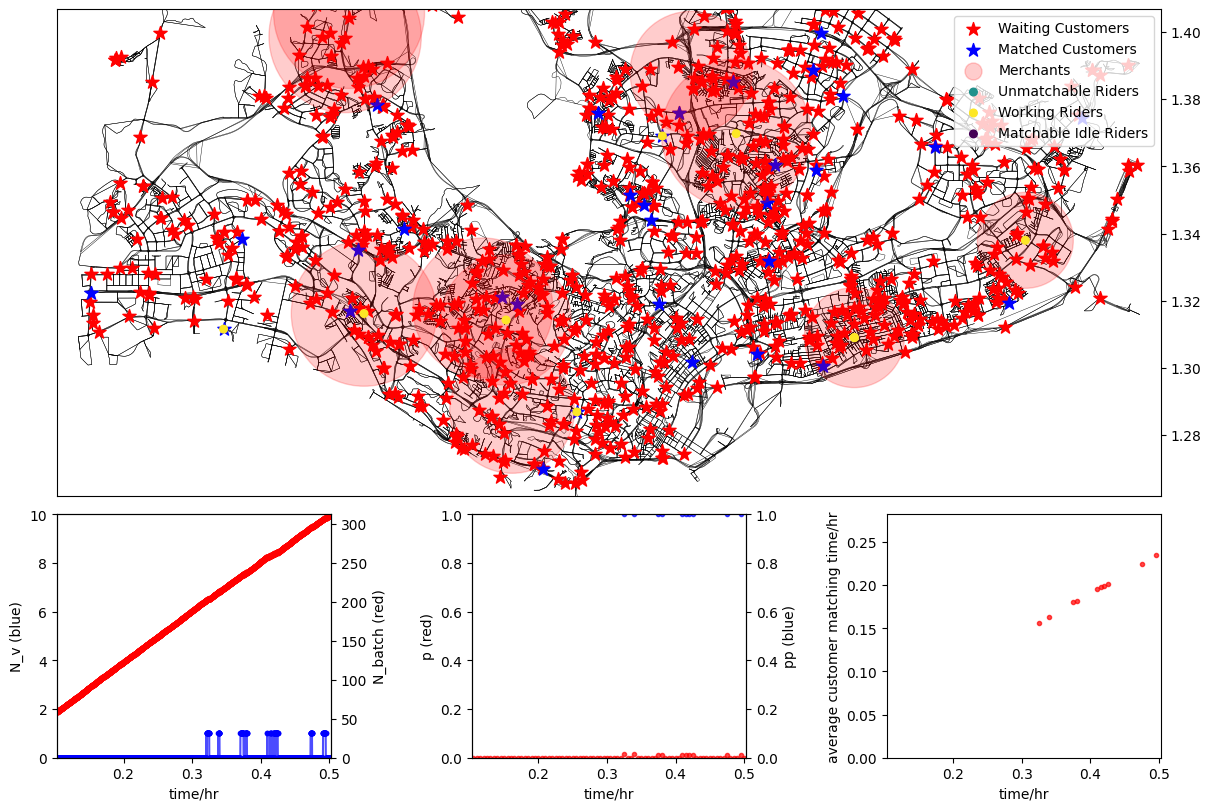

In [22]:
# # marking the x-axis and y-axis
fig = plt.figure(constrained_layout=True, figsize=[12, 8])
gs = fig.add_gridspec(3, 3)
ax0 = fig.add_subplot(gs[:2, :3])
ox.plot.plot_graph(
    G_sgp, ax=ax0, node_size=0, bgcolor='w', edge_color='k',
    edge_linewidth=.3, save=0, show=False, close=False
)
# nx.draw_networkx(G_sgp, pos=pos, ax=ax0, node_size=15, node_color='gray', with_labels=False)
ax = ax0.twinx()
ax.set_xlim(ax0.get_xlim())
ax.set_ylim(ax0.get_ylim())
ax.set_aspect((north - south)*aspect_ratio / (east - west))

ax2 = fig.add_subplot(gs[2, 0])
ax2.set_ylabel('N_v (blue)')
ax2.set_xlabel('time/hr')
ax3 = ax2.twinx()
ax3.set_ylabel('N_batch (red)')
ax3.set_xlabel('time/hr')
ax4 = fig.add_subplot(gs[2, 1])
ax4.set_ylabel('p (red)')
ax4.set_xlabel('time/hr')
ax4.set_ylim([0, 1])
ax5 = ax4.twinx()
ax5.set_ylabel('pp (blue)')
ax5.set_xlabel('time/hr')
ax5.set_ylim([0, 1])
ax6 = fig.add_subplot(gs[2, 2])
ax6.set_ylabel('average customer matching time/hr')
ax6.set_xlabel('time/hr')

# plt.tight_layout()


scat2 = ax.scatter([], [], color='red', marker='*', s=100, label='Waiting Customers')  # for waiting customers
scat3 = ax.scatter([], [], color='blue', marker='*', s=100, label='Matched Customers')  # for matched customers
scat4 = ax.scatter([], [], color='red', alpha=0.2, label='Merchants', s=150)  # for merchants

# riders
color = np.ones(N) * 0.5
scat = ax.scatter(-10*np.ones(len(rider_set)), -10*np.ones(len(rider_set)), s=30, c=np.ones(N) * 0.5, vmin=0, vmax=1, label='Unmatchable Riders')
ax.scatter(-10*np.ones(len(rider_set)), -10*np.ones(len(rider_set)), s=30, c=np.ones(N), vmin=0, vmax=1, label='Working Riders')
ax.scatter(-10*np.ones(len(rider_set)), -10*np.ones(len(rider_set)), s=30, c=np.zeros(N), vmin=0, vmax=1, label='Matchable Idle Riders')
ax.legend(loc='upper right')

line2, = ax2.plot([], [], 'b.-', alpha=0.7)
line3, = ax3.plot([], [], 'r.-', alpha=0.7)
line4, = ax4.plot([], [], 'r.-', alpha=0.7)
line5, = ax5.plot([], [], 'b.-', alpha=0.7)
line6, = ax6.plot([], [], 'r.-', alpha=0.7)

while c <= 15000:
    idle_rider_IDs = []
    for i in range(N):
        if rider_set[i].state=='idle' and rider_set[i].if_matchable:
            idle_rider_IDs.append(rider_set[i].ID)
    
    q = q_bar * cR**2 / Delta**2
    virtual_plat.acquire_order(q)
    
    if int(c%match_period)==0:
        matched_batches, matched_rider_IDs, matched_merchants, avg_W_cq = virtual_plat.match(
            idle_rider_IDs, rider_set
        )
    else:
        matched_batches, matched_rider_IDs, matched_merchants, avg_W_cq = np.array([]), [], [], np.nan
    
    num_matched_cust = matched_batches.size if int(c%match_period)==0 else np.nan
    try:
        p = num_matched_cust / (num_matched_cust + virtual_plat.num_accumulated_order/k)
    except:
        # when there is no order
        p = np.nan
    num_matched_rider_IDs = num_matched_cust // k
    try:
        pp = num_matched_rider_IDs / len(idle_rider_IDs)
    except:
        pp = np.nan

    # move use single processor
    rider_set = move_rider(
        rider_set, t_resolution, matched_rider_IDs, matched_batches, matched_merchants, dec_var
    )
    # for multiprocessing, uncomment the following lines
#     moved_rider_set = move_all_riders()
#     moved_rider_set = [item for sublist in moved_rider_set for item in sublist]
#     rider_set = moved_rider_set
    
    # update delivered customers
    delivered_customers_set = []
    for each_rider in rider_set:
        delivered_customers_set.append(each_rider.newly_finished_destination)
        
    for delivered_customer in delivered_customers_set:
        if delivered_customer in list(virtual_plat.matched_customer_df['node_ID']):
            virtual_plat.matched_customer_df = virtual_plat.matched_customer_df.drop(
                virtual_plat.matched_customer_df.loc[
                    virtual_plat.matched_customer_df['node_ID']==delivered_customer, 'waiting_time'
                ].astype(float).idxmax()
            )
    virtual_plat.matched_customer_df.index = range(virtual_plat.matched_customer_df.shape[0])
    
    time_now = c * t_resolution
    x_axis.append(time_now)
    num_idle_rider_IDs_set.append(len(idle_rider_IDs))
    num_accumulated_batch_set.append(virtual_plat.num_accumulated_order/k)  # continuous
    p_set.append(p)
    pp_set.append(pp)
    avg_W_cq_set.append(avg_W_cq)
    
    if c>=5000 and c%2==0:
        # plot customers
        if virtual_plat.customer_df.shape[0]>0:
            cust_pos = np.array(virtual_plat.customer_df[['position_x', 'position_y']].to_numpy())
            scat2.set_offsets(cust_pos)
        if virtual_plat.matched_customer_df.shape[0] > 0:
            cust_pos_m = np.array(virtual_plat.matched_customer_df[['position_x', 'position_y']].to_numpy())
            scat3.set_offsets(cust_pos_m)
        
        # plot riders
        for i in range(N):
            if rider_set[i].state == 'idle' and rider_set[i].if_matchable:
                color[i] = 0
            elif rider_set[i].state == 'working' or rider_set[i].state == 'stop':
                color[i] = 1
            elif rider_set[i].state == 'idle' and rider_set[i].if_matchable==False:
                color[i] = 0.5
        scat.set_array(color)
        scat.set_offsets(
            np.array( [ [rider_set[i].position[0], rider_set[i].position[1]] for i in range(N)] )
        )
        
        # plot merchants
        merchant_pos = [[get_node_xy(i)[0], get_node_xy(i)[1]] for i in merchant_node_set]
        scat4.set_offsets(np.array(merchant_pos))
        acc_orders_by_merchant = []
        for i in merchant_node_set:
            acc_orders_by_merchant.append(virtual_plat.customer_df.loc[virtual_plat.customer_df['merchant_node']==i].shape[0])
        scat4.set_sizes(150 + np.array(acc_orders_by_merchant)**2)
        
        line2.set_data(x_axis, num_idle_rider_IDs_set)
        ax2.set_ylim([min(num_idle_rider_IDs_set), N])
        line3.set_data(x_axis, num_accumulated_batch_set)
        ax3.set_ylim([0, max(num_accumulated_batch_set)])
        line4.set_data(x_axis, p_set)
        line5.set_data(x_axis, pp_set)
        line6.set_data(x_axis, avg_W_cq_set)

        ax2.set_xlim([max(0, time_now - 0.4), time_now])
        ax3.set_xlim([max(0, time_now - 0.4), time_now])
        ax4.set_xlim([max(0, time_now - 0.4), time_now])
        ax5.set_xlim([max(0, time_now - 0.4), time_now])
        ax6.set_xlim([max(0, time_now - 0.4), time_now])
        if np.isnan(np.nanmax(avg_W_cq_set))==False:
            ax6.set_ylim([0, 1.2 * np.nanmax(avg_W_cq_set)])

        display.clear_output(wait=True)
        display.display(plt.gcf())
    
        fig.savefig('./res_img/%i%.4f.png'%(time_now//10, time_now-time_now//10*10 ), dpi=75)
    c += 1
    

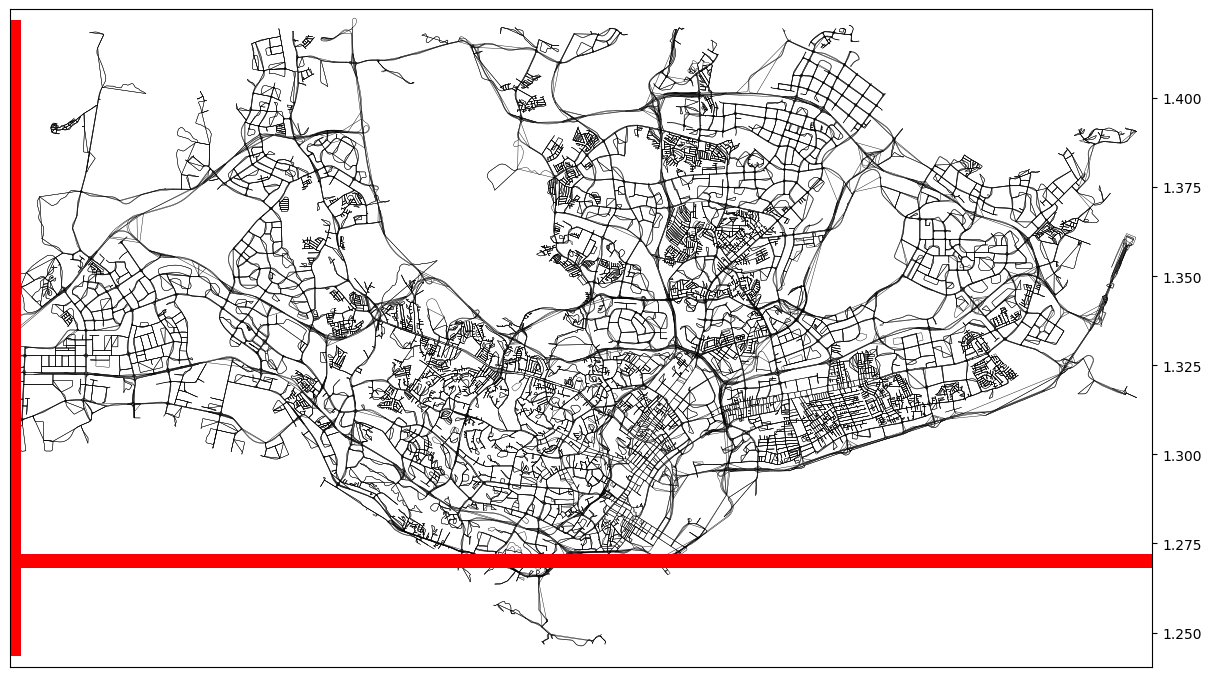

In [21]:
fig = plt.figure(constrained_layout=True, figsize=[12, 10])
gs = fig.add_gridspec(3, 3)
ax0 = fig.add_subplot(gs[:2, :3])

ox.plot.plot_graph(
    G_sgp, ax=ax0, node_size=0, bgcolor='w', edge_color='k',
    edge_linewidth=.3, save=0, show=False, close=False, bbox = (north, south, east, west)
)
ax0.plot([west*1.00001, west*1.00001], [north, south], 'b', lw=10)
ax0.plot([west, east], [south*1.02, south*1.02], 'b', lw=10)

ax = ax0.twinx()
# ax.set_ylim(ax0.get_ylim())
ax.set_aspect((north - south)*1.84 / (east - west))

ax.plot([west*1.00001, west*1.00001], [north, south], 'r', lw=10)
ax.plot([west, east], [south*1.02, south*1.02], 'r', lw=10)

In [17]:
# # make gif
# import glob
# from PIL import Image
# def make_gif(frame_folder):
#     frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.png"))]
#     frame_one = frames[0]
#     frame_one.save('./res_img/demo0.gif', format="GIF", append_images=frames,
#                save_all=True, duration=35, loop=0)
    

# make_gif("./res_img/")

In [20]:
import cv2
import numpy as np
import glob

img_array = []
for filename in sorted(glob.glob("res_img/*.png")):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('./res_img/project.mp4',cv2.VideoWriter_fourcc('m', 'p', '4', 'v') , 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

import os
for i in sorted(glob.glob("res_img/*.png")):
    os.remove(i)